In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from base_mlp import BaseMLPEstimator
from data_model import DataModel
from double_mlp import DoubleMLPEstimator
from estimate import base_dml, prop_dml, prop_dml_internal_stats
from utils import np_to_torch, torch_to_np
from tqdm.notebook import tqdm


p = 20
n = 200
rho = 0
theta = 1
lamb = 1

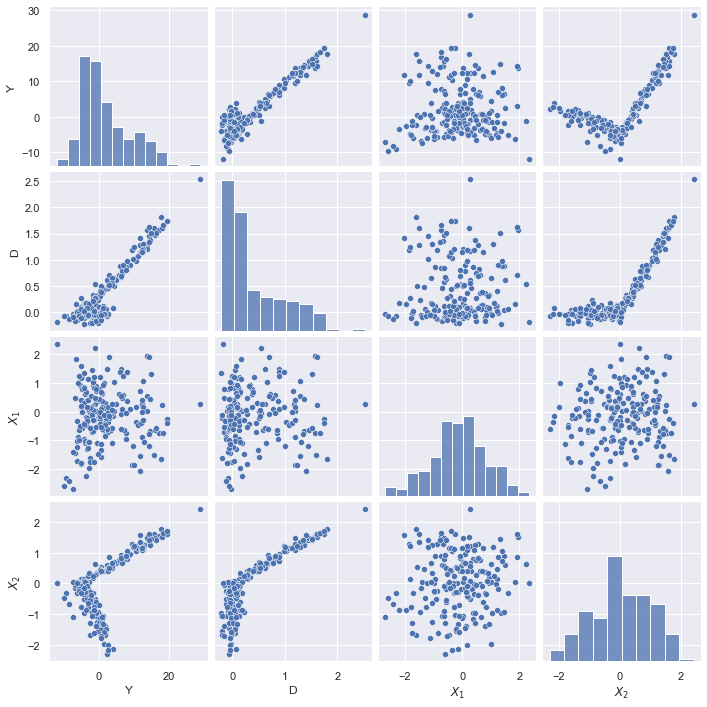

In [2]:
true_model = DataModel(p, rho, theta, lamb)

n_plot = 200
Y, D, X = true_model.generate(n_plot)
Y, D, X = torch_to_np(Y), torch_to_np(D), torch_to_np(X)

df = pd.DataFrame(data=np.concatenate((Y.reshape(n_plot, 1), D.reshape(n_plot, 1), X[:, 0:2]), 1), 
                  columns=['Y', 'D', '$X_1$', '$X_2$'])
sns.set(font_scale=1)
sns.pairplot(df)
sns.set(rc={'figure.figsize': (10, 10)})
plt.savefig('results/pairs.pdf', bbox_inches="tight")
plt.show()

In [3]:
def run_experiments(theta, lambds, num_exp=10):
    df = pd.DataFrame()
    for lamb in tqdm(lambds):
        for i in range(num_exp):
            true_model = DataModel(p, rho, theta, lamb)
            Y, D, X = true_model.generate(n)
            theta_hat, dm_dl, dm2, bias, v2 = base_dml(Y, D, X, true_model)
            df_tmp = pd.DataFrame({'model' : ['mlp'],
                                    'rho' : rho,
                                    'lamb' : lamb,
                                    'theta' : theta,
                                    'theta.hat' : theta_hat,
                                    'dtheta' : theta_hat - theta,
                                    'bias' : bias/v2,
                                    'dm.dl' : dm_dl/v2,
                                    'dm2' : dm2/v2
                                    })
            df = pd.concat([df, df_tmp])
    
    return df

lambds = np.linspace(-0.5, 0.5, 11, endpoint=True)
df = run_experiments(theta, lambds, num_exp=100)
df_avg = df.groupby(['model', 'rho', 'lamb', 'theta']).mean().reset_index()

  0%|          | 0/11 [00:00<?, ?it/s]

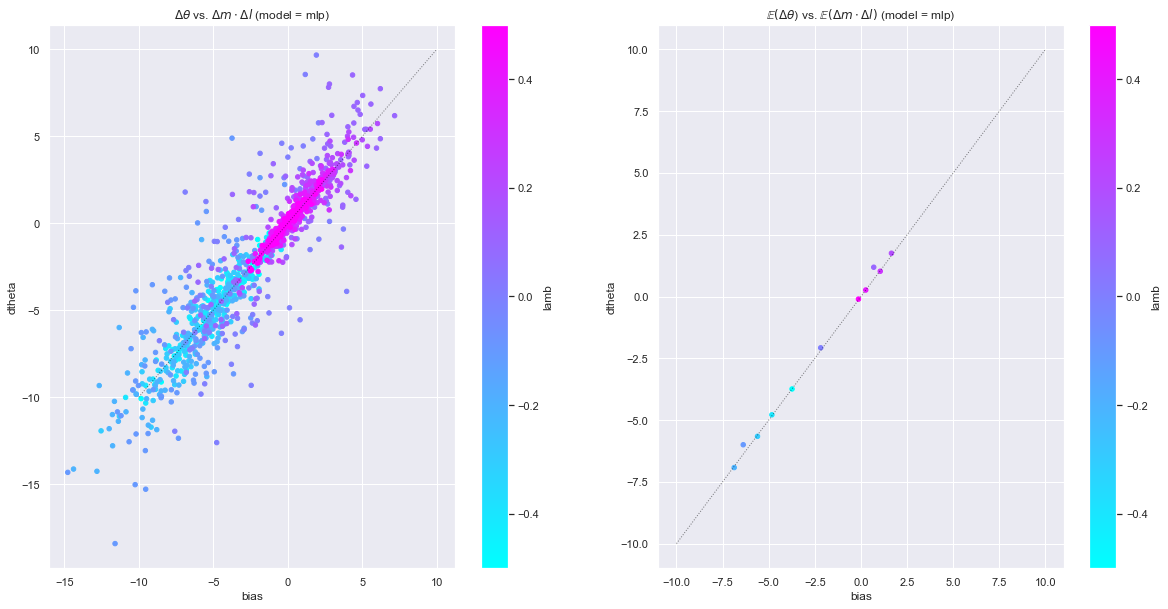

In [4]:
def plot_results(df, axs):
    df_tmp = df[df['model'] == 'mlp']
    df_tmp.plot.scatter(x='bias', y='dtheta', c='lamb', cmap=cm, ax=axs)
    axs.plot([-10, 10], [-10, 10], color='black', alpha=0.5, linewidth=1, linestyle=':')

cm = plt.cm.get_cmap('cool')
_, axs = plt.subplots(1, 2, figsize=(20,10)) 

plot_results(df, axs[0])
axs[0].set_title('$\\Delta \\theta$ vs. $\\Delta m \cdot \\Delta l$ (model = mlp)')

plot_results(df_avg, axs[1])
axs[1].set_title('$\mathbb{E}(\\Delta \\theta$) vs. $\mathbb{E}(\\Delta m \cdot \\Delta l)$ (model = mlp)')

plt.savefig('results/bias_double_ml', bbox_inches='tight')
plt.show()

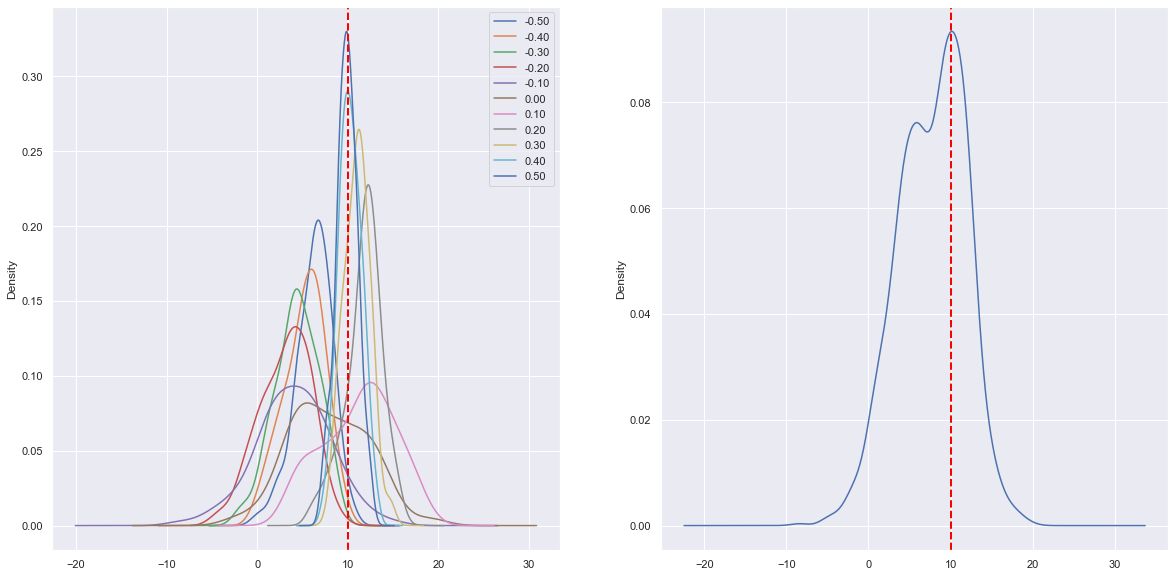

In [5]:
_, axs = plt.subplots(1, 2, figsize=(20,10)) 
for lamb in lambds:
    df_tmp = df[df['lamb'] == lamb]
    df_tmp['theta.hat'].plot.kde(ax=axs[0], label='{:.2f}'.format(lamb))
axs[0].legend()
axs[0].axvline(x=theta, linestyle='--', linewidth=2., color='red')

df['theta.hat'].plot.kde(ax=axs[1])
axs[1].axvline(x=theta, linestyle='--', linewidth=2., color='red')

plt.savefig('results/theta_double_ml', bbox_inches='tight')
plt.show()

In [4]:
def run_experiments(theta, lambds, num_exp=10):
    df = pd.DataFrame()
    for lamb in tqdm(lambds):
        for i in range(num_exp):
            true_model = DataModel(p, rho, theta, lamb)
            Y, D, X = true_model.generate(n)
            theta_hat, dm_dl, dm2, bias, v2 = prop_dml(Y, D, X, true_model, reg_labmda=1)
            df_tmp = pd.DataFrame({'model' : ['mlp'],
                                    'rho' : rho,
                                    'lamb' : lamb,
                                    'theta' : theta,
                                    'theta.hat' : theta_hat,
                                    'dtheta' : theta_hat - theta,
                                    'bias' : bias/v2,
                                    'dm.dl' : dm_dl/v2,
                                    'dm2' : dm2/v2
                                    })
            df = pd.concat([df, df_tmp])
    
    return df

lambds = np.linspace(-0.5, 0.5, 11, endpoint=True)
df = run_experiments(theta, lambds, num_exp=100)
df_avg = df.groupby(['model', 'rho', 'lamb', 'theta']).mean().reset_index()

  0%|          | 0/11 [00:00<?, ?it/s]

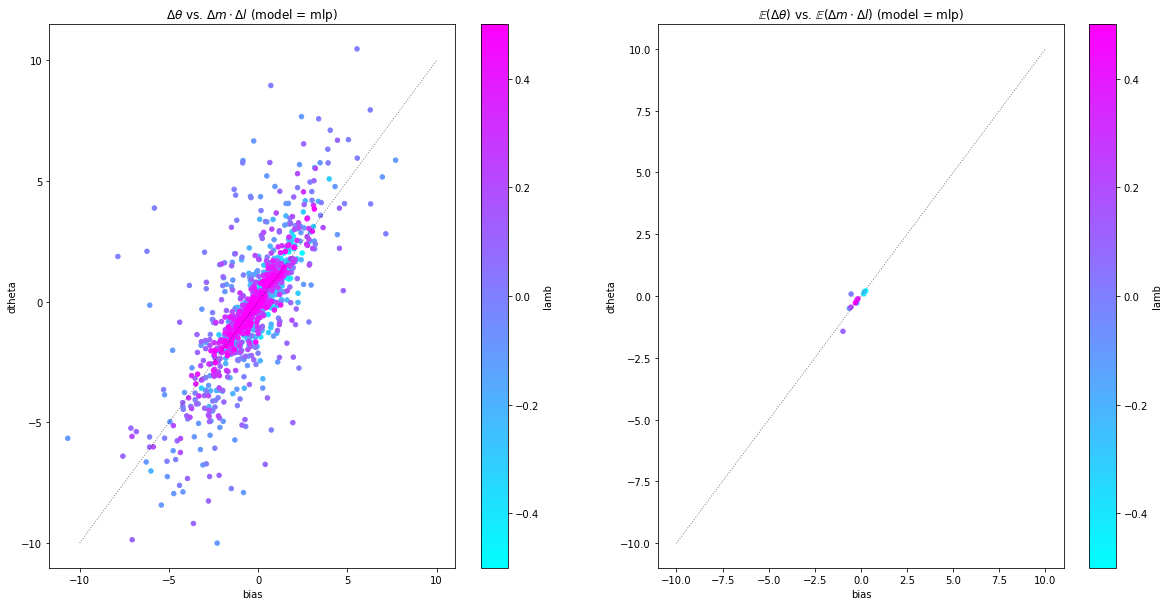

In [5]:
def plot_results(df, axs):
    df_tmp = df[df['model'] == 'mlp']
    df_tmp.plot.scatter(x='bias', y='dtheta', c='lamb', cmap=cm, ax=axs)
    axs.plot([-10, 10], [-10, 10], color='black', alpha=0.5, linewidth=1, linestyle=':')

cm = plt.cm.get_cmap('cool')
_, axs = plt.subplots(1, 2, figsize=(20,10)) 

plot_results(df, axs[0])
axs[0].set_title('$\\Delta \\theta$ vs. $\\Delta m \cdot \\Delta l$ (model = mlp)')

plot_results(df_avg, axs[1])
axs[1].set_title('$\mathbb{E}(\\Delta \\theta$) vs. $\mathbb{E}(\\Delta m \cdot \\Delta l)$ (model = mlp)')

plt.savefig('results/bias_ours', bbox_inches='tight')
plt.show()

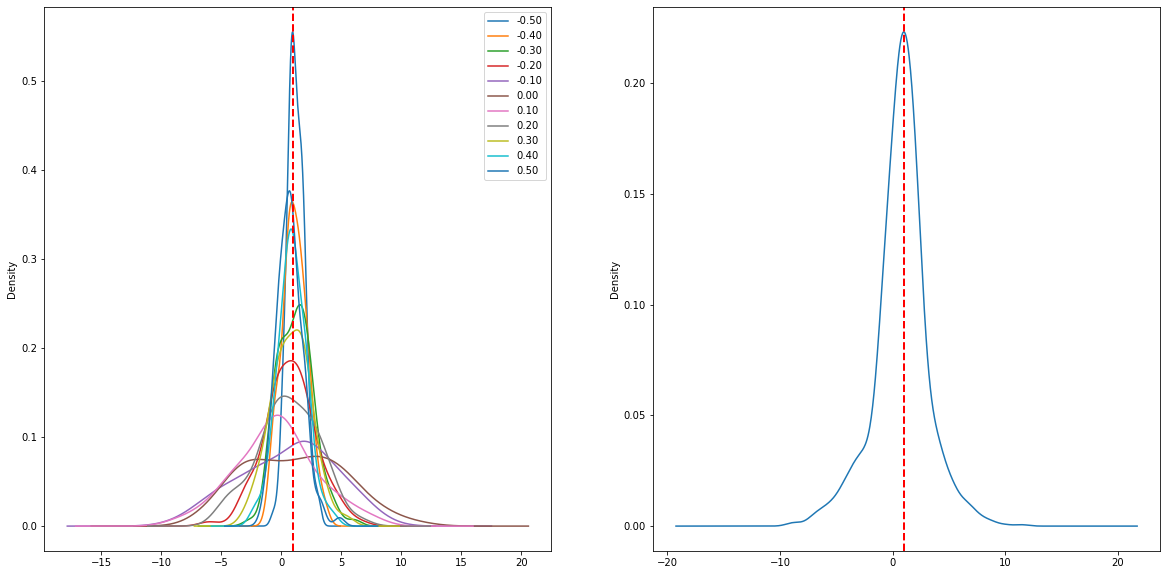

In [6]:
_, axs = plt.subplots(1, 2, figsize=(20,10)) 
for lamb in lambds:
    df_tmp = df[df['lamb'] == lamb]
    df_tmp['theta.hat'].plot.kde(ax=axs[0], label='{:.2f}'.format(lamb))
axs[0].legend()
axs[0].axvline(x=theta, linestyle='--', linewidth=2., color='red')

df['theta.hat'].plot.kde(ax=axs[1])
axs[1].axvline(x=theta, linestyle='--', linewidth=2., color='red')

plt.savefig('results/theta_ours', bbox_inches='tight')
plt.show()

In [7]:
def run_experiments(theta, gammas, num_exp=10):
    lamb = 1
    df = pd.DataFrame()
    for gamma in tqdm(gammas):
        for i in range(num_exp):
            true_model = DataModel(p, rho, theta, lamb)
            Y, D, X = true_model.generate(n)
            dm, dl = prop_dml_internal_stats(Y, D, X, true_model, reg_labmda=gamma)
            df_tmp = pd.DataFrame({'model' : ['mlp'],
                                    'rho' : rho,
                                    'lamb' : lamb,
                                    'theta' : theta,
                                    'gamma' : gamma,
                                    'dm.2' : dm ** 2,
                                    'dl.2' : dl ** 2,
                                    'dm.dl': dm * dl,
                                    'bias': dm * dl - theta * (dm ** 2),
                                    'variance': (1 + theta ** 2) * (dm ** 2) + 1 * (dl ** 2) - 2 * theta * 1 * (dm * dl)
                                    })
            df = pd.concat([df, df_tmp])
    
    return df

gammas = np.logspace(-3, 1, num=5)
df = run_experiments(theta, gammas, num_exp=100)
df_avg = df.groupby(['model', 'rho', 'gamma', 'theta']).mean().reset_index()

  0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
def plot_results(df, axs, key):
    for gamma in gammas:
        df_tmp = df[df['gamma'] == gamma]
        df_tmp[key].plot.hist(alpha=0.5, ax=axs, label='{:.1e}'.format(gamma))     

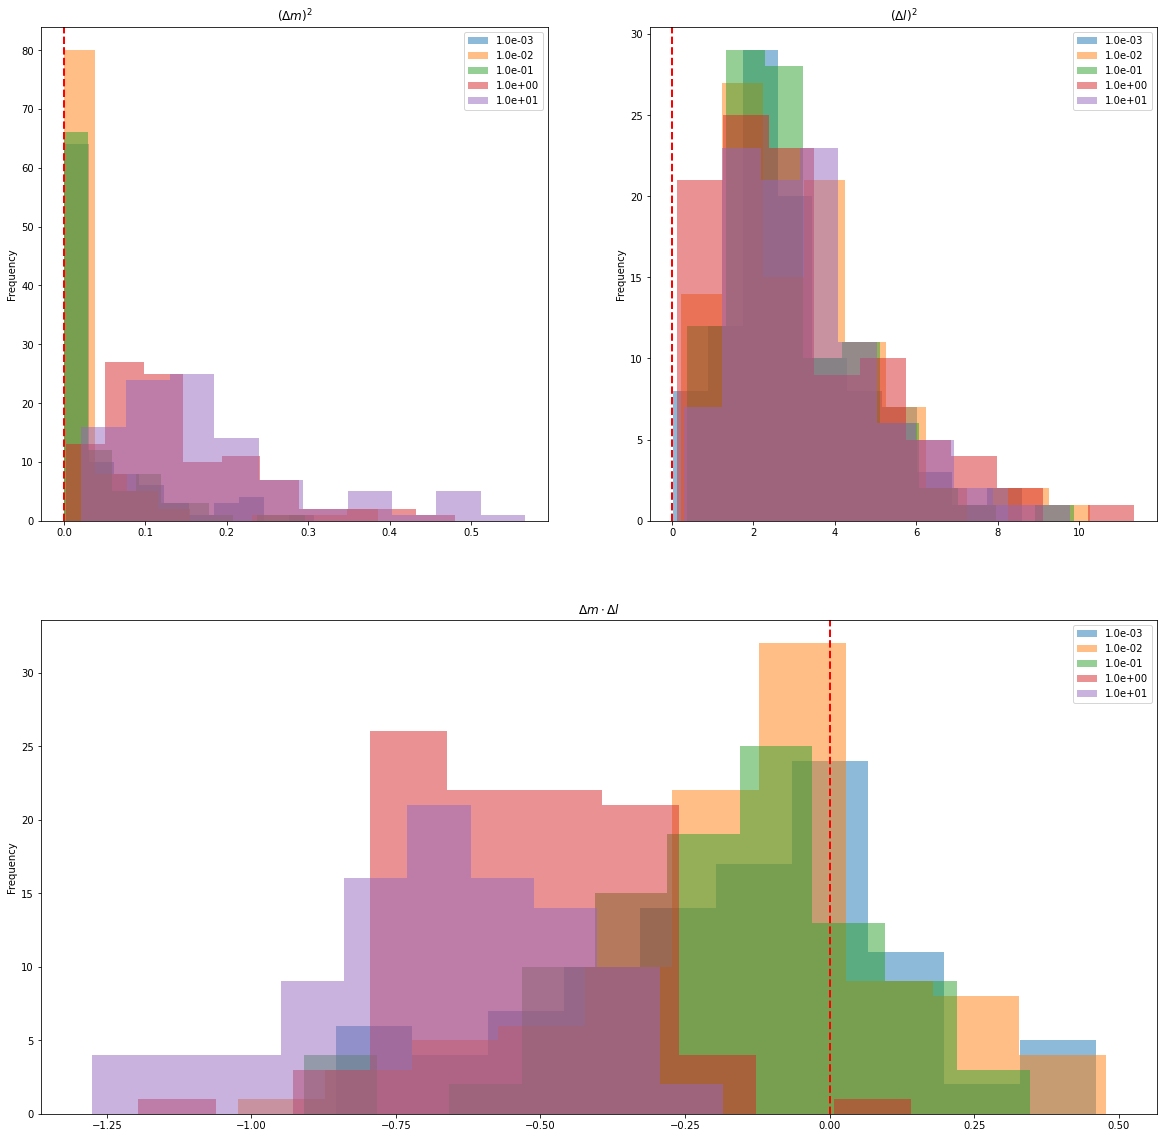

In [27]:
fig = plt.figure(figsize=(20,20))
grid = fig.add_gridspec(2, 2)

axs = fig.add_subplot(grid[0,0])
plot_results(df, axs, 'dm.2')
axs.set_title('$(\\Delta m)^2$')
axs.legend()
axs.axvline(x=0, linestyle='--', linewidth=2., color='red')

axs = fig.add_subplot(grid[0,1])
plot_results(df, axs, 'dl.2')
axs.set_title('$(\\Delta l)^2$')
axs.legend()
axs.axvline(x=0, linestyle='--', linewidth=2., color='red')

axs = fig.add_subplot(grid[1,:])
plot_results(df, axs, 'dm.dl')
axs.set_title('$\\Delta m \cdot \\Delta l$')
axs.legend()
axs.axvline(x=0, linestyle='--', linewidth=2., color='red')

plt.savefig('results/internal_stats', bbox_inches='tight')
plt.show()

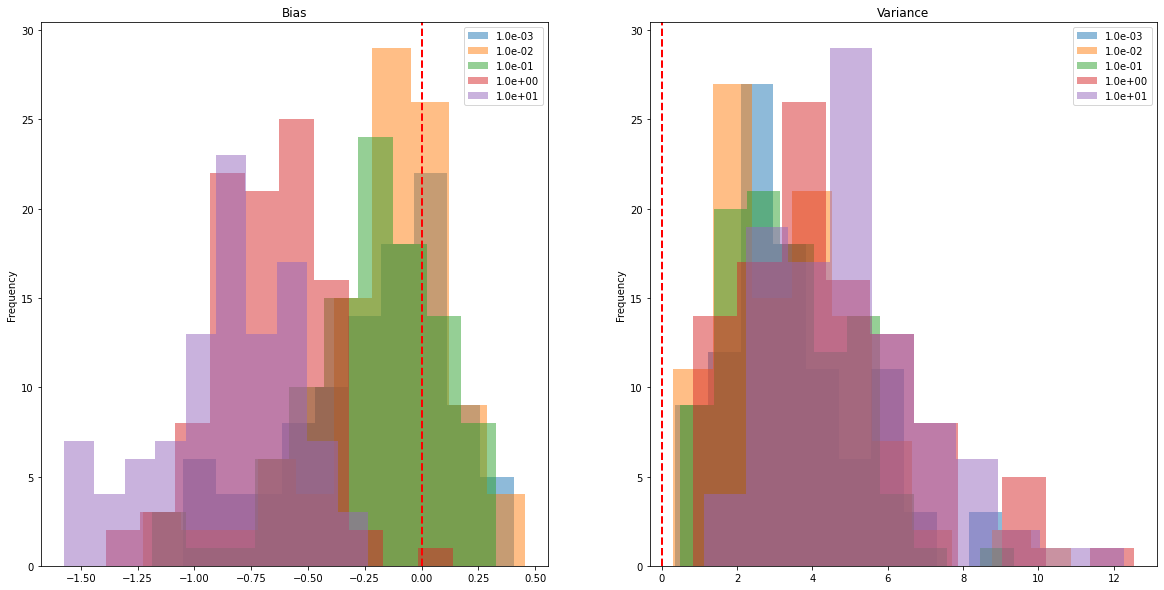

In [28]:
_, axs = plt.subplots(1, 2, figsize=(20,10)) 

plot_results(df, axs[0], 'bias')
axs[0].set_title('Bias')
axs[0].legend()
axs[0].axvline(x=0, linestyle='--', linewidth=2., color='red')

plot_results(df, axs[1], 'variance')
axs[1].set_title('Variance')
axs[1].legend()
axs[1].axvline(x=0, linestyle='--', linewidth=2., color='red')

plt.savefig('results/external_stats', bbox_inches='tight')
plt.show()